## Notes for Pyspark: Working Between RDDs and Arrays

Version Information: 

I have installed Pyspark via pip inside of an Anaconda Python 3.5 environment. That sets me at Python for Java and Pyspark versions *py4j-0.10.4 pyspark-2.2.1* respectively.

In [1]:
import pyspark
import numpy as np
from splearn.rdd import ArrayRDD
from sklearn.datasets import fetch_mldata

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize']=[10, 10]
%matplotlib inline


sc = pyspark.SparkContext(appName="ArrayRDDs")

### Preparing Data

There are plenty of ways of getting a hold of data. 

#### Option 1:
Several of the larger Python libraries, including Scikit-Learn, have methods for grabbing data online. 

Scikit-Learn's data loading utilities:
1. fetch_mldata (method used below):
http://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_mldata.html
2. Dataset utilities docs:
http://scikit-learn.org/stable/datasets/index.html


### MNIST Data

> The MNIST database of handwritten digits, available from http://yann.lecun.com/exdb/mnist/, has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. 

Read more on the MNIST dataset here: http://yann.lecun.com/exdb/mnist/

In [2]:
# I have provided a directory to save data to within this repo.
DATA_DIR = '../data'
mnist = fetch_mldata('MNIST original', data_home=DATA_DIR)

# fetch_ml() returns a dictionary. Take a look at its fields.
X = mnist['data']
y = mnist['target']

print('Our dataset, X, is of type {}'.format(type(X)))
print('Our labels, y, are of type {}'.format(type(y)))

Our dataset, X, is of type <class 'numpy.ndarray'>
Our labels, y, are of type <class 'numpy.ndarray'>


Note: 

Numpy is a gem of a library which focuses on operations for n-dimensional arrays. If you find yourself frustrated with how Spark is holding (and hiding) your data, working between Spark's data structures and Numpy can be helpful. More on that soon.

### Resilient Distributed Datasets (RDDs)

Let's take a closer look at Spark's RDDs. Let's cast our numpy nd-arrays as RDDs and see what we can do.

In [3]:
x_rdd = sc.parallelize(X, 2)
y_rdd = sc.parallelize(y, 2)

print('x_rdd is of type {}'.format(type(x_rdd)))
print('y_rdd is of type {}'.format(type(y_rdd)))

x_rdd is of type <class 'pyspark.rdd.RDD'>
y_rdd is of type <class 'pyspark.rdd.RDD'>


There are a lot of methods associated with Spark's RDD class. If you are not familiar with Python or Jupyter notebooks, you can check those methods here by using tab completion. For example, to see the methods of our RDD class, try the following:

```python
x_rdd.`<tab>`
```

This will bring up a list of all the methods associated with that object. Unfortunately, there are not many convenient ways of inspecting data when cast as RDDs. If you are wanting to get a closer look at the data, you typically have to `collect` the data from the RDD format:

In [5]:
# collect will return a list
x_list = x_rdd.collect()

The list format is a bit more natural to work with if you are familiar with Python, but going between lists and RDDs can be a bit tedious. Let me show you a potentially helpful library that marries some features of Numpy with Pyspark.

### Sparkit-Learn

Sparkit-learn is a library that I find really helpful when working with Spark.

> About:

>Sparkit-learn aims to provide scikit-learn functionality and API on PySpark. The main goal of the library is to create an API that stays close to sklearn's.

>The driving principle was to "Think locally, execute distributively." To accomodate this concept, the basic data block is always an array or a (sparse) matrix and the operations are executed on block level.

Sparkit-learn's GitHub: https://github.com/lensacom/sparkit-learn

`Sparkit-Learn` brings to the possibility of using `Scikit-Learn` models within Pyspark. This can be really nice, but not all of the `Scikit-Learn` library is supported.

What I like about `Sparkit-Learn` is that it makes working with RDDs and data in general much more friendly. It's `ArrayRDD` class adds back some sorely missed methods when handling data.

In [13]:
from splearn.rdd import ArrayRDD

x_rddarray = ArrayRDD(x_rdd)
y_rddarray = ArrayRDD(y_rdd)

print('Each distributed subset of your RDD is called a "block" in an ArrayRDD.')
print('x_rddarray contains {} blocks'.format(x_rddarray.blocks))

# Get the type of the array's blocks
print("x_rddarray's blocks are of type {}".format(x_rddarray.dtype))

Each distributed subset of your RDD is called a "block" in an ArrayRDD.
x_rddarray contains 2 blocks
x_rddarray's blocks are of type <class 'numpy.ndarray'>


In [32]:
# Collecting will still return a list for you:
collected_list = x_rddarray.collect()
print('collected_list is of type {}'.format(type(collected_list)))

# But now indexing and slicing will work for you.
early_elems = x_rddarray[0:1].collect()
elem0 = early_elems[0]
print('The zeroth element of our data is an array of shape {}'.format(elem0.shape))

collected_list is of type <class 'list'>
The zeroth element of our data is an array of shape (34816, 784)


What I find to be most helpful is the ability to go directly from RDDs to Numpy arrays:

In [5]:
x_array = x_rddarray.toarray()
x_array.shape

(70000, 784)

In [6]:
# Reshaping data is much easier with Numpy
x_array = x_array.reshape(70000, 28, 28)
x_array.shape

(70000, 28, 28)

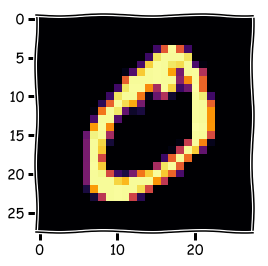

In [7]:
# You'll never get a plot of your data from an RDD
plt.xkcd()
plt.imshow(x_array[0], cmap='inferno')
plt.show()

In [9]:
# We then can go back to RDDs.
new_rdd = sc.parallelize(x_array, 2)

new_rddarray = ArrayRDD(new_rdd)
new_rddarray.shape

(70000, 28, 28)

### Challenge

What happens if you want to reshape your data, but the data is too big to fit in memory? Can you find a way to get ArrayRDDs to work for you?

Hint: ArrayRDD's slicing could come in handy.

In [12]:
# Blocks are distributed subsets of your RDD.
# How might we use this?
for block in x_rddarray:
    reshaped = block.toarray().reshape(block.shape[0], 28, 28)
    print(reshaped.shape)

(34816, 28, 28)
(35184, 28, 28)
